## TORA (benchmark 9)

In [6]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots
const NNA = NeuralNetworkAnalysis

using NeuralNetworkAnalysis: _forward_network

In [7]:
@load "/home/mforets/.julia/dev/NeuralNetworkAnalysis/models/Sherlock-Benchmark-9/b9.jld2" controller

1-element Array{Symbol,1}:
 :controller

In [8]:
@taylorize function benchmark9!(dx, x, p, t)
    x₁, x₂, x₃, x₄, u = x

    aux = 0.1 * sin(x₃)
    dx[1] = x₂
    dx[2] = -x₁ + aux
    dx[3] = x₄
    dx[4] = u
    dx[5] = zero(u)
end

In [9]:
X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6]) * 0.95

U₀ = Universe(1)
prob = @ivp(x' = benchmark9!(x), dim: 5, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>[5]);

In [16]:
plant = ControlledPlant(prob, controller, vars_idx);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
solver = ZonotopeBounder()

@time sol = solve(plant, T=10.0, Tsample=2.0, alg_nn=solver, alg=alg)
solz = overapproximate(sol, Zonotope);

  4.114660 seconds (84.43 M allocations: 5.532 GiB, 28.37% gc time)


In [17]:
length(solz)

5

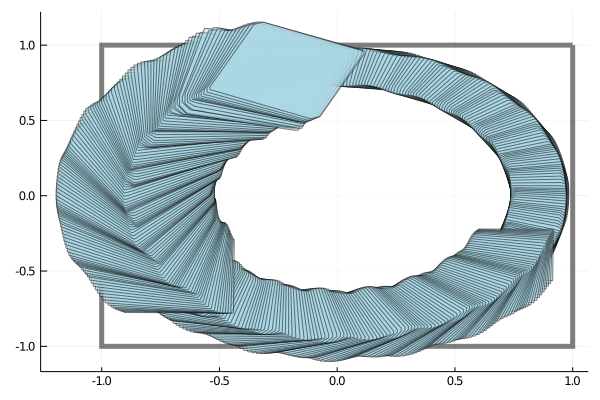

In [18]:
plot(BallInf(zeros(2), 1.0), vars=(1, 2), color=:white, linecolor=:black, lw=5.0)

plot!(LazySets.Projection(X₀, [1, 2]), alpha=1., color=:orange)
plot!(solz, vars=(1, 2), color=:lightblue)

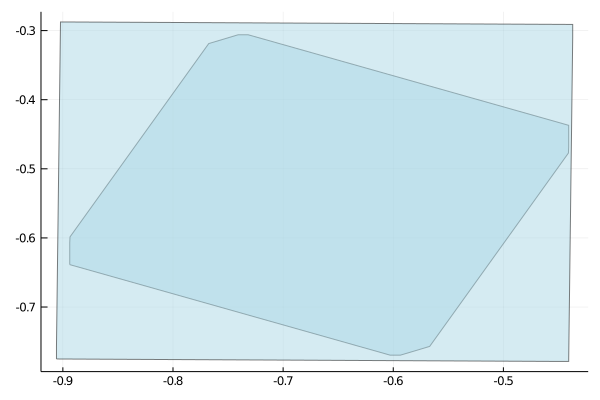

In [23]:
#plot(BallInf(zeros(2), 1.0), vars=(1, 2), color=:white, linecolor=:black, lw=5.0)

plot(solz[end-1][end], vars=(1, 2), color=:lightblue)
plot!(solz[end][1], vars=(1, 2), color=:lightblue)

In [ ]:
plot(solz, vars=(0, 1), color=:lightblue, lw=0.1)
plot(solz, vars=(0, 4), color=:lightblue, lw=0.1)

In [ ]:
solver = MaxSens(tight=true)
U₀ = forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

In [ ]:
solver = BaB(ϵ=5.0)
NNA._forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

In [ ]:
solver = ZonotopeBounder()
U₀ = _forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

## Splitting by hand

In [48]:
H = overapproximate(set(solz[3][end]), Hyperrectangle)
Hs = split(H, [3, 3, 3, 3, 1]);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)

# without split
@time sol4 = solve(IVP(prob.s, H), T=1.0, alg=alg)
sol4z = overapproximate(sol4, Zonotope);

# with split
@time sol4s = solve(IVP(prob.s, Hs), T=1.0, alg=alg)
sol4zs = overapproximate(sol4s, Zonotope);

  0.589978 seconds (9.85 M allocations: 660.749 MiB, 33.51% gc time)
 39.330305 seconds (681.98 M allocations: 44.688 GiB, 28.01% gc time)


In [89]:
#all([!isdisjoint(Hsi, Z, algorithm="exact") for Hsi in Hs])

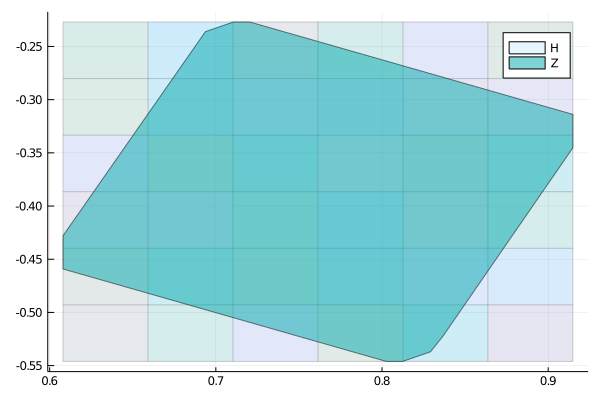

In [67]:
Z = set(solz[3][end])
H = overapproximate(Z, Hyperrectangle)
Hs = split(H, [6,6,1,1,1]);

plot(LazySets.Projection(H, [1, 2]), alpha=.1, lab="H")
plot!([LazySets.Projection(Hsi, [1, 2]) for Hsi in Hs],alpha=.1, lab="")
plot!(LazySets.Projection(Z, [1, 2]), lab="Z")

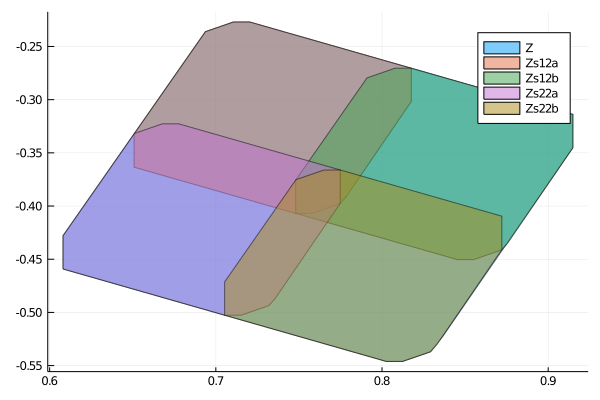

In [102]:
Zs = split(Z, 1)
Zs1 = Zonotope(Vector(Zs[1].center), Matrix(Zs[1].generators))
Zs2 = Zonotope(Vector(Zs[2].center), Matrix(Zs[2].generators))

Zs12 = split(Zs1, 2)
Zs22 = split(Zs2, 2)
Zs12a = Zonotope(Vector(Zs12[1].center), Matrix(Zs12[1].generators))
Zs12b = Zonotope(Vector(Zs12[2].center), Matrix(Zs12[2].generators))
Zs22a = Zonotope(Vector(Zs22[1].center), Matrix(Zs22[1].generators))
Zs22b = Zonotope(Vector(Zs22[2].center), Matrix(Zs22[2].generators))

plot(LazySets.Projection(Z, [1, 2]), lab="Z")
plot!(LazySets.Projection(Zs12a, [1, 2]), lab="Zs12a")
plot!(LazySets.Projection(Zs12b, [1, 2]), lab="Zs12b")
plot!(LazySets.Projection(Zs22a, [1, 2]), lab="Zs22a")
plot!(LazySets.Projection(Zs22b, [1, 2]), lab="Zs22b")

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.782833208331875, -0.3386779732160652, 102.62687796508261, 20.56600417001573, 0.0], [-0.021375390559468296 0.09724179628013303 … 0.0 0.0; -0.047856485601261586 -0.04343364014463483 … 0.0 0.0; … ; 0.0 0.0 … 3.552713678800502e-15 0.0; 0.0 0.0 … 0.0 1.136e-321])

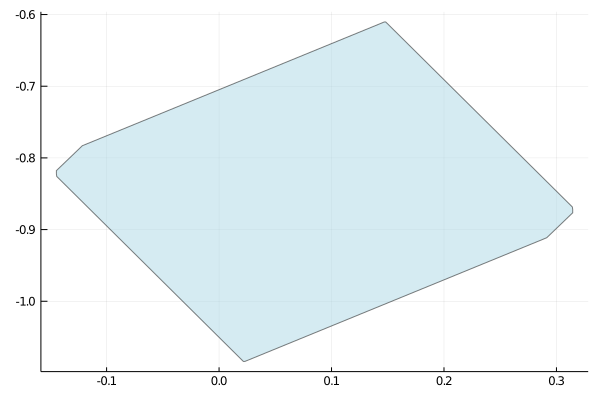

In [49]:
plot(sol4z[end], vars=(1, 2), color=:lightblue)

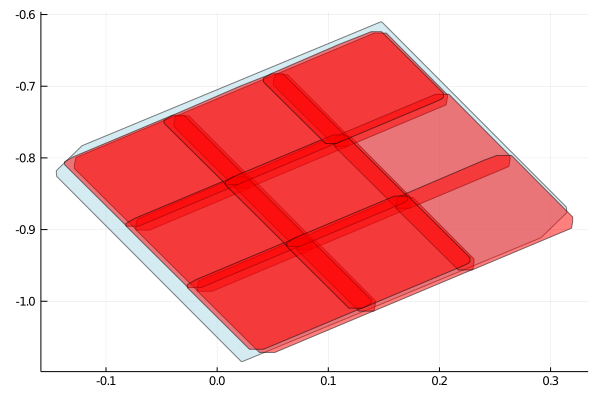

In [50]:
plot!([sol4zs[i][end] for i in 1:16], vars=(1, 2), color=:red)

## Solving each segment separately

In [ ]:
# data
solver = ZonotopeBounder()

X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6])
U₀ = Universe(1)
ivp = @ivp(x' = benchmark9!(x), dim: 5, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>[5]);
cpost = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
S = system(ivp)
Q₀ = initial_state(ivp)
sampling_time = 1.0
ti = 0.0
time_span = 0 .. 3.0
st_vars = vars_idx[:state_vars]
network = controller;

In [ ]:
# solve first interval
@time begin
    X₀ = LazySets.Projection(Q₀, st_vars)
    P₀ = X₀
    X₀h = overapproximate(X₀, Hyperrectangle)
    U₀ = NNA._forward_network(solver, network, X₀h)
    Q₀ = P₀ × U₀
    dt = ti .. (ti + sampling_time)
    sol = ReachabilityAnalysis.post(cpost, IVP(S, Q₀), dt);
    solz = overapproximate(sol, Zonotope);
end;

In [ ]:
plot(LazySets.Projection(X₀, [1, 2]), alpha=1., color=:orange)
plot!(solz, vars=(1, 2), color=:lightblue)

In [ ]:
# solve second interval
@time begin
    Z = solz[end]
    X₀ = ReachabilityAnalysis.project(Z, vars=st_vars) |> set
    P₀ = X₀
    U₀ = NNA._forward_network(solver, network, P₀)
    Q₀ = P₀ × U₀
    ti += sampling_time
    dt = ti .. (ti + sampling_time)
    
    sol2 = ReachabilityAnalysis.post(cpost, IVP(S, Q₀), dt);
    sol2z = overapproximate(sol2, Zonotope);
end;
U₀

In [ ]:
plot!(sol2z, vars=(1, 2), color=:lightblue)